# App-Rating Prediction Project Using OpenML Dataset

In [ ]:
# google drive link to aceess the data: https://drive.google.com/file/d/1Ns2x4y0TrOnHBvtoeqYtQSgS4hz8CHzb/view?usp=sharing

## 0. Brief Read-Me

### Project Description
- This project involves developing a ML model to predict app ratings (represented by stars) in Google Play Store.
- Our model will analyze various features, potentially including the number of installs, app category, keywords in the name, price, type of currency, and last update date. To train and test the model, we will use the OpenML dataset “Google-Play-Store-Apps”, whose dataset ID is 43798.

### Goals
- The goal of this project is to identify two things:
    - features that are influential / correlate to (predicting) Rating using statistical techniques we learned in this course.
    - a trained model to predict rating that overperforms the benchmark we will set up later in the beginning of the section "Training".

## 1. Libraries & Dataset Installation

### Library Installation

In [1]:
# pip installation, feel free to comment/uncomment here to omit unnecessary output
# !pip install openml

In [121]:
# data installation
import openml

# data science
import pandas as pd
import numpy as np
import re

# visualization
import matplotlib.pyplot as plt

# helper
import time
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import squareform  # for DBSCAN clustering

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

### Constant Variables

In [3]:
SEED = 42  # random seed
DATASET_ID = 43798  # for loading data from OpenML
SPLIT_RATIO = 0.2  # for train_test_split

### Loading Dataset

In [4]:
dataset = openml.datasets.get_dataset(DATASET_ID)
X, _, categorical_indicator, attribute_names = dataset.get_data(dataset_format="dataframe")
y = X['Rating']
X = X.drop('Rating', axis=1)
X.head()

,App_Name,App_Id,Category,Rating_Count,Installs,Minimum_Installs,Maximum_Installs,Free,Price,Currency,...,Developer_Website,Developer_Email,Released,Last_Updated,Content_Rating,Privacy_Policy,Ad_Supported,In_App_Purchases,Editors_Choice,Scraped_Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,10+,10.0,15,True,0.0,USD,...,https://beniyizibyose.tk//,jean21101999gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,64.0,"5,000+",5000.0,7662,True,0.0,USD,...,https://webserveis.netlify.app/,webserveisgmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,50+,50.0,58,True,0.0,USD,...,None,vnacrewitgmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,10+,10.0,19,True,0.0,USD,...,http://www.climatesmarttech.com/,climatesmarttech2gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,None,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,100+,100.0,478,True,0.0,USD,...,http://www.horodyski.com.pl,rmilekhorodyskigmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


### Brief (But Important) Null Check

In [5]:
print(f"Null values in X: \n{X.isnull().sum()}")
print(f"Null values in y (Rating): {y.isnull().sum()}")

Null values in X: 
App_Name              30479
App_Id                    0
Category                  0
Rating_Count          22883
Installs                107
Minimum_Installs        107
Maximum_Installs          0
Free                      0
Price                     0
Currency                135
Size                    196
Minimum_Android        6530
Developer_Id          19314
Developer_Website    760835
Developer_Email          31
Released              71053
Last_Updated              0
Content_Rating            0
Privacy_Policy       420953
Ad_Supported              0
In_App_Purchases          0
Editors_Choice            0
Scraped_Time              0
dtype: int64
Null values in y (Rating): 22883


- (1) We found there is no instance with "Rating" being between 0.0 and 1.0 (both ends are exclusive).
- (2) We found that there are two definitive relationships:
    - iff "Rating" == 0, "Rating_Count" == 0
    - iff "Rating" == None, "Rating_Count" == None
- By (1), we can safely say that users can rate an app with scores only between 1.0 and 5.0 (both ends are inclusive).
- By (2) (and indirectly (1)), We can safely define that "Rating" == 0.0 and "Rating" == None are the same.

In [6]:
temp = pd.concat([X, y], axis=1)
print(f"(1) Check if there is any rating that is between 0.0 and 1.0 (exclusive): {len(temp[(temp['Rating']>0) & (temp['Rating']<1)])}")
print(f"    Number of null values in Rating: {len(temp[temp['Rating'].isnull()])}")
print(f"    Number of 0.0 in Rating: {len(temp[temp['Rating']==0.0])}")

print(f"(2) Proof of definitive relationship: {all([
    (np.isnan(sum(temp[temp['Rating'].isnull()].Rating_Count.astype(float)))),
    (sum(temp[temp['Rating']==0.0].Rating_Count)==0.0)
])}")
del temp

(1) Check if there is any rating that is between 0.0 and 1.0 (exclusive): 0
    Number of null values in Rating: 22883
    Number of 0.0 in Rating: 1059762
(2) Proof of definitive relationship: True


### Try-and-Error Notes

- Our first thought was to remove all the istances with "Rating" == 0.0 or "Rating" == None because it means "the app has not been rated yet", which seems these might introduce noises to the predictions.
- However, we eventually discovered that using entire dataset results in better performance by performing predictions both with and without those instances.
- Thus, we are not going to remove any instances in this dataset although we still need to impute "Rating" with 0.0.
- See the commented-out code segments with "REDUCED" on top of the cell through this notebook.

In [7]:
# Impute Rating and Rating_Count with 0.0 
X['Rating_Count'] = X['Rating_Count'].fillna(0.0)
y = y.fillna(0.0)

### Train Test Split
- For tree models, cross validation suffices since the computational cost is not very expensive.
- For deep learning models, we will later create validation set for hyperparameter tuning.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_RATIO, random_state=SEED)
Rating_Count_train = X_train[['Rating_Count']].copy()  # for benchmark
Rating_Count_test = X_test[['Rating_Count']].copy()    # for postprocess
print(f"(Train_Size, Test_Size) = ({len(X_train)}, {len(X_test)})")

(Train_Size, Test_Size) = (1850355, 462589)


In [9]:
# REDUCED
# temp = pd.concat([X_train, y_train], axis=1)
# temp = temp[temp['Rating_Count']>0]
# X_train = temp.drop('Rating', axis=1)
# y_train = temp['Rating']
# print(f"Instances left: {len(X_train)}")

"""
Instances left: 984334
"""

'\nInstances left: 984334\n'

We are now ready to explore the dataset!

## 2. EDA

### Data Types

In [10]:
print(X_train.info())
print("\n")
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1850355 entries, 140961 to 2219110
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App_Name           object 
 1   App_Id             object 
 2   Category           object 
 3   Rating_Count       float64
 4   Installs           object 
 5   Minimum_Installs   float64
 6   Maximum_Installs   int64  
 7   Free               bool   
 8   Price              float64
 9   Currency           object 
 10  Size               object 
 11  Minimum_Android    object 
 12  Developer_Id       object 
 13  Developer_Website  object 
 14  Developer_Email    object 
 15  Released           object 
 16  Last_Updated       object 
 17  Content_Rating     object 
 18  Privacy_Policy     object 
 19  Ad_Supported       bool   
 20  In_App_Purchases   bool   
 21  Editors_Choice     bool   
 22  Scraped_Time       object 
dtypes: bool(4), float64(3), int64(1), object(15)
memory usage: 289.4+ MB
None


<class

### Visualization Functions

In [11]:
def plot_categorical_distribution(df: pd.DataFrame, df_name: str, col: str, top_10=False):
    temp = df.groupby(col).size()
    if top_10:
        temp = temp.sort_values(ascending=False).iloc[:10]
    mode = temp.idxmax()
    print(f"mode: {temp.idxmax()} \nratio: {round(temp.max()/len(df)*100, 2)}%")
    plt.bar(temp.index, temp.values)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f"{'Top10 ' if top_10 else ''}Distribution of {col} in {df_name}")
    plt.show();

def plot_continuous_distribution(df: pd.DataFrame, df_name: str, col: str, log=False):
    n, bins, _ = plt.hist(df[col], log=log)
    len_df = len(df)
    mode = ''
    width = bins[1]-bins[0]
    ratio = 0.0
    bin_name = 'bin'
    for i, num in enumerate(n):
        temp_ratio = num/len_df
        if temp_ratio > ratio:
            ratio = temp_ratio
            mode = bins[i]
            bin_name = 'bin'+str(i)
    print(f"mode: {bin_name} [{mode}, {mode+width}) \nratio: {round(ratio*100, 2)}%")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f"Distribution of {col} in {df_name}")
    plt.show();

def plot_target_hist(df: pd.DataFrame, target: pd.Series, df_name: str, col: str):
    unique_vals = df[col].unique()
    temp = pd.concat([df, target], axis=1)
    for unique_val in unique_vals:
        plot_continuous_distribution(temp[temp[col]==unique_val], df_name, 'Rating')

### 1st Imputation

In [12]:
print(f"X_train Null: \n{X_train.isnull().sum()} \n")
print(f"X_test Null: \n{X_test.isnull().sum()}")

X_train Null: 
App_Name              24417
App_Id                    0
Category                  0
Rating_Count              0
Installs                 84
Minimum_Installs         84
Maximum_Installs          0
Free                      0
Price                     0
Currency                108
Size                    152
Minimum_Android        5219
Developer_Id          15378
Developer_Website    608688
Developer_Email          26
Released              56861
Last_Updated              0
Content_Rating            0
Privacy_Policy       336826
Ad_Supported              0
In_App_Purchases          0
Editors_Choice            0
Scraped_Time              0
dtype: int64 

X_test Null: 
App_Name               6062
App_Id                    0
Category                  0
Rating_Count              0
Installs                 23
Minimum_Installs         23
Maximum_Installs          0
Free                      0
Price                     0
Currency                 27
Size                     44
Mini

- Features with null values:
    - App_Name
    - Installs
    - Minimum_Installs
    - Currency
    - Size
    - Minimum_Android
    - Developer_Id
    - Developer_Website
    - Developer_Email
    - Released
    - Privacy_Policy

#### 1. App_Name
- dtype: string
- Null values: (train) 24417, (test) 6062

In [13]:
X_train[['App_Name']].head()

,App_Name
140961,Live PD Calculator
875217,Kilegg
2234998,TourVisio B2B
719396,Forelook
347975,Extreme Flight


- We are not going to use this feature since it is not imputable.
    - We don't have access to some other features that are enough to extract / predict app names.
    - App names seem not that important to rating.
    - We don't want to drop instances with null App_Name, rather we drop this feature.
- However, we can think of creating new features such as length of App_Name. See "App_Name" section in the step "Feature Engineering".

#### 2. Installs & Minimum_Installs
- dtype: string (int)
- Null values: (train) 84, (test) 23

In [14]:
X_train[['Installs', 'Minimum_Installs', 'Maximum_Installs']].head()

,Installs,Minimum_Installs,Maximum_Installs
140961,"1,000+",1000.0,3861
875217,"1,000+",1000.0,1173
2234998,50+,50.0,64
719396,0+,0.0,0
347975,"1,000+",1000.0,1477


- We can observe 3 things from those 3 features about installs (proof codes below):
    - (1) "Installs" is string of "Minium_Installs" + '+'
    - (2) iff "Installs" == None, "Minimum_Installs" == None
    - (3) "Maximum_Installs" is between the "Minimum_Installs" bin and next bin (maximum value is compared to inf)

In [15]:
%%time
# proof of the observations
installs_train = X_train['Installs'].dropna().apply(lambda x: re.sub(r"[,\+]", "", x)).astype(float)
installs_test = X_test['Installs'].dropna().apply(lambda x: re.sub(r"[,\+]", "", x)).astype(float)
min_installs_train = X_train['Minimum_Installs'].dropna()
min_installs_test = X_test['Minimum_Installs'].dropna()
max_installs_train = X_train['Maximum_Installs'].loc[min_installs_train.index]
max_installs_test = X_test['Maximum_Installs'].loc[min_installs_test.index]
bins = sorted(list(set(min_installs_train.unique().tolist() + min_installs_test.unique().tolist())))+[float('inf')]
len_train = len(min_installs_train)
len_test = len(min_installs_test)

print(f"(1) & (2): {all([
    [all([installs_train.iloc[i] == min_installs_train.iloc[i] for i in range(len_train)]),
     all([installs_test.iloc[i] == min_installs_test.iloc[i] for i in range(len_test)])]])}")
print(f"(3): {all([
    [all([(min_installs_train.iloc[i] <= max_installs_train.iloc[i]) & 
          (max_installs_train.iloc[i] <= bins[bins.index(min_installs_train.iloc[i])+1]) 
          for i in range(len_train)]),
     all([(min_installs_test.iloc[i] <= max_installs_test.iloc[i]) & 
          (max_installs_test.iloc[i] <= bins[bins.index(min_installs_test.iloc[i])+1]) 
          for i in range(len_test)])]
])}")
del installs_train, installs_test, min_installs_train, min_installs_test, max_installs_train, max_installs_test, len_train, len_test

(1) & (2): True
(3): True
CPU times: user 28.5 s, sys: 120 ms, total: 28.6 s
Wall time: 28.7 s


- Thus, we can find true values for missing "Minimum_Installs" using bins and
- drop "Installs" since "Minimum_Installs" and "Installs" carry basically the same information in different data types.

In [16]:
# impute "Minimum_Installs" using index and bins defined above
null_min_ins_train = X_train[X_train['Minimum_Installs'].isnull()]
null_min_ins_test = X_test[X_test['Minimum_Installs'].isnull()]

def min_installs_imputer(null_min_ins_df, bins):
    max_inss = null_min_ins_df['Maximum_Installs'].to_dict()
    ret = null_min_ins_df.copy()
    for (i, max_ins) in max_inss.items():
        min_ins = 0.0
        for bin in bins:
            if bin>max_ins:
                break
            min_ins = bin
        ret.loc[i, 'Minimum_Installs'] = min_ins
    return ret

null_min_ins_train = min_installs_imputer(null_min_ins_train, bins)
null_min_ins_test = min_installs_imputer(null_min_ins_test, bins)
X_train = X_train.fillna(null_min_ins_train)
X_test = X_test.fillna(null_min_ins_test)

In [17]:
X_train.loc[null_min_ins_train.index][['Installs', 'Minimum_Installs', 'Maximum_Installs']].head()

,Installs,Minimum_Installs,Maximum_Installs
1266688,None,0.0,0
1615398,None,1000000.0,1828988
1860821,None,0.0,0
1162511,None,100.0,165
43569,None,50000.0,72087


In [18]:
del null_min_ins_train, null_min_ins_test

#### 3. Currency
- dtype: string
- Null values: (train) 108, (test) 27

In [19]:
X_train[X_train['Currency'].isnull()].head()

,App_Name,App_Id,Category,Rating_Count,Installs,Minimum_Installs,Maximum_Installs,Free,Price,Currency,...,Developer_Website,Developer_Email,Released,Last_Updated,Content_Rating,Privacy_Policy,Ad_Supported,In_App_Purchases,Editors_Choice,Scraped_Time
1266688,Idle Royal Stories,com.outloud.idleroyalstories,Simulation,0.0,None,0.0,0,False,0.0,None,...,http://outloud.games,bizoutloud.games,None,"May 21, 2021",Everyone,None,True,False,False,2021-06-15 21:40:55
1615398,RuneScape - Open World Fantasy MMORPG,com.jagex.runescape.android,Role Playing,0.0,None,1000000.0,1828988,False,0.0,None,...,https://support.runescape.com/,rsmobilesupport.jagex.com,None,"Jun 11, 2021",Teen,https://www.jagex.com/terms/privacy,False,False,False,2021-06-16 03:00:44
190484,Snickometer : Cricket Prediction Tool,com.snickometer.cricket,Sports,24.0,"5,000+",5000.0,7944,False,0.0,NaN,...,http://boxcar.digital/,adaschmidt89gmail.com,"Nov 15, 2018","May 07, 2021",Everyone,http://boxcar.digital/privacypolicies/snickome...,True,False,False,2021-06-15 23:33:42
1860821,Jackal Squad - Tank Hero Pixel World War,com.rocket.jackal.squad,Adventure,0.0,None,0.0,0,False,0.0,None,...,http://rocketadsltd.com/,customer.serviceonesoft.com.vn,None,"Dec 22, 2020",Everyone,http://rocketstudio.com.vn/space_shooter/polic...,True,False,False,2021-06-16 06:25:25
1162511,Staging Claremont Club,com.staging.TCC,Health Fitness,0.0,None,100.0,165,False,0.0,None,...,http://www.smarthealthclubs.com,supportsmarthealthclubs.com,None,"Jun 07, 2021",Everyone,https://staging-tcc.smarthealthclubs.com/priva...,False,False,False,2021-06-16 14:56:34


mode: USD 
ratio: 99.94%


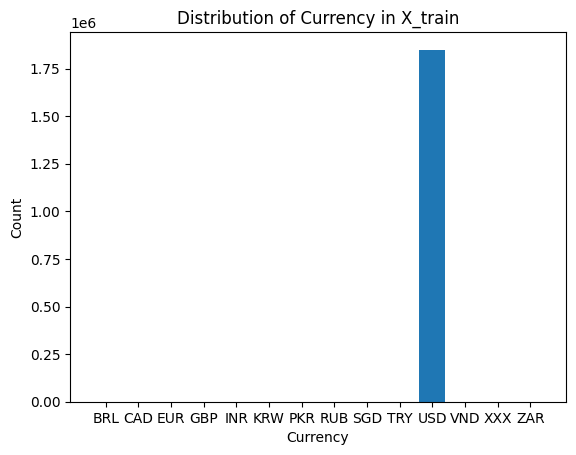

mode: USD 
ratio: 99.95%


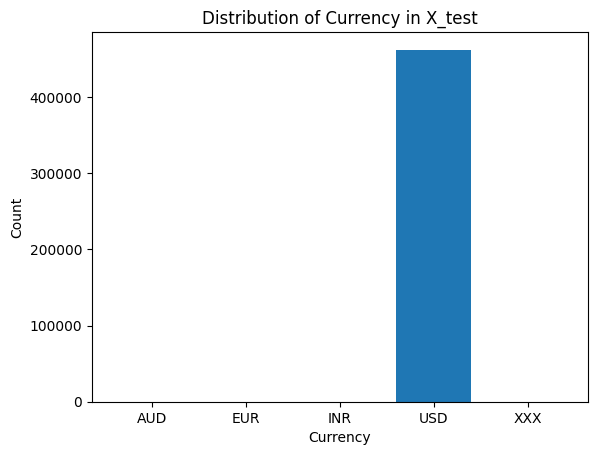

In [20]:
# distribution of unique currencies
plot_categorical_distribution(X_train, 'X_train', 'Currency')
plot_categorical_distribution(X_test, 'X_test', 'Currency')

- Since the number of unique values is small, and 'USD' is dominating the distributions (>99.9%), we can safely impute 'Currency' with 'USD' even though it might be wrong.

In [21]:
X_train['Currency'] = X_train['Currency'].fillna('USD')
X_test['Currency'] = X_test['Currency'].fillna('USD')

#### 4. Size
- dtype: string
- Null values: (train) 152, (test) 44

In [22]:
X_test[['Size']].head()

,Size
1843548,14M
421026,47M
2036441,6.8M
1525791,6.6M
1748509,3.4M


- We can impute this feature by converting it into float type with unifying the unit to M (there are k, M, and G) and using a simple strategy such as median since the number of null instances is much smaller than the size of dataset.

In [23]:
# converter
def size_to_M(size):
    if not size or isinstance(size, float):
        return float('nan')
    converter = {'k': 1/1024, 'M': 1.0, 'G': 1024.0}
    size = size.replace(',', '')
    pattern = r"(\d[\d, \.]*)(\w)"
    match = re.search(pattern, size)
    if match:
        return float(converter[match.group(2)]*float(match.group(1)))
    return float('nan')
X_train['Size'] = X_train['Size'].apply(size_to_M)
X_test['Size'] = X_test['Size'].apply(size_to_M)

mode: bin0 [0.003125, 153.60281250000003) 
ratio: 96.57%


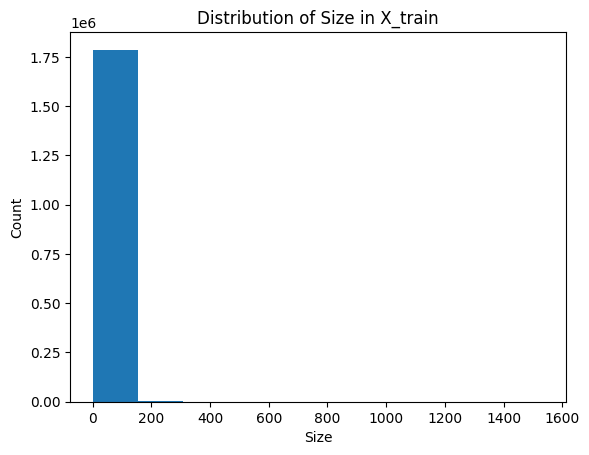

mode: bin0 [0.00322265625, 153.602900390625) 
ratio: 96.56%


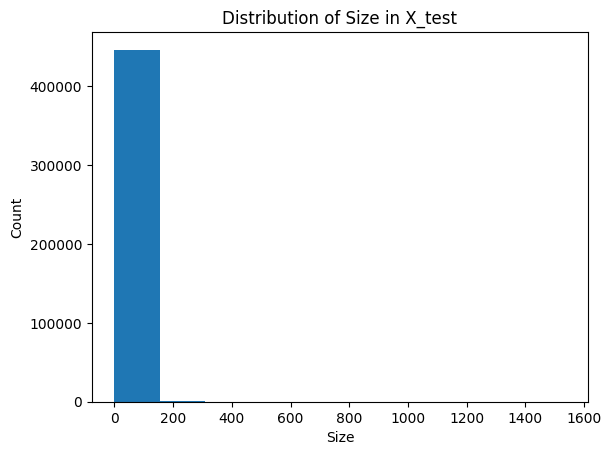

In [24]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Size')
plot_continuous_distribution(X_test, 'X_test', 'Size')

mode: bin0 [0.003125, 15.3028125) 
ratio: 62.27%


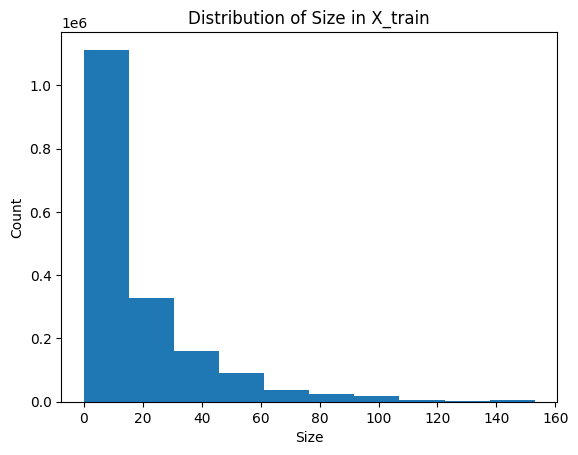

mode: bin0 [0.00322265625, 15.302900390625) 
ratio: 62.3%


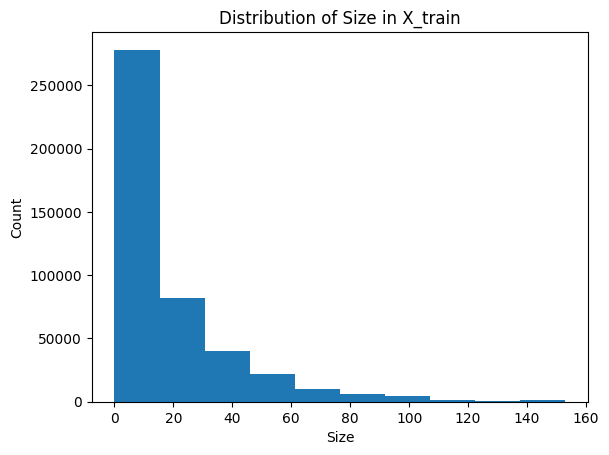

In [25]:
# plot distribution in the range of "Size" being smaller than 154
plot_continuous_distribution(X_train[X_train['Size']<154], 'X_train', 'Size')
plot_continuous_distribution(X_test[X_test['Size']<154], 'X_train', 'Size')

- It seems median works the best for "Size" imputation since the distributions skew to the right.

In [26]:
size_median = X_train['Size'].median()
X_train['Size'] = X_train['Size'].fillna(size_median)
X_test['Size'] = X_test['Size'].fillna(size_median)

#### 5. Minimum_Android
- dtype: string
- Null values: (train) 5219, (test) 1311

In [27]:
X_train[['Minimum_Android']].head()

,Minimum_Android
140961,7.0 and up
875217,5.0 and up
2234998,4.3 and up
719396,4.1 and up
347975,2.3 and up


In [28]:
temp = X_train.groupby('Minimum_Android').size().sort_values(ascending=False)
temp_sum = 0
temp_index = 0
while temp_sum<len(X_train)*0.99:
    temp_sum+=temp.iloc[temp_index]
    temp_index+=1
selected_categories = temp.index[:temp_index].tolist()
print(f"Number of unique values: {len(temp)}\nNumber of values occupying 99%: {temp_index}")
print(f"Selected Categories:\n{selected_categories}")

Number of unique values: 143
Number of values occupying 99%: 19
Selected Categories:
['4.1 and up', '5.0 and up', '4.4 and up', '4.0.3 and up', '4.0 and up', '4.2 and up', '6.0 and up', '2.3 and up', '5.1 and up', 'Varies with device', '4.3 and up', '7.0 and up', '2.2 and up', '2.3.3 and up', '3.0 and up', '2.1 and up', '8.0 and up', '4.4W and up', '1.6 and up']


- We can reduce the number of categories of this feature 143 to 19+1 by adding "Others" to the 19 categories that dominate 99% of instances.
- By doing so, we can impute this feature at the same time.

In [29]:
def min_andr_imputer(val):
    if not val or val not in selected_categories:
        return 'Others'
    return val
X_train['Minimum_Android'] = X_train['Minimum_Android'].apply(min_andr_imputer)
X_test['Minimum_Android'] = X_test['Minimum_Android'].apply(min_andr_imputer)

#### 6. Features about Developer

In [30]:
X_train[['Developer_Id', 'Developer_Website', 'Developer_Email']].head()

,Developer_Id,Developer_Website,Developer_Email
140961,Omni LK,NaN,rahul.meghwallenskart.in
875217,cm city media GmbH,http://www.cmcitymedia.de,androidcmcitymedia.de
2234998,SAN TSG,http://www.santsg.com/,tvsupportsantsg.com
719396,Genisis,NaN,developer.genisisgmail.com
347975,Aleksey Taranov,http://www.altarsoft.com,webmasteraltarsoft.com


- It is neither realistic nor significant to impute these features. We are going to drop them.
- It might be beneficial to feature engineer if 'Developer_Website' is null or not since it has many null values (train: 608688, test: 152147).

#### 7. Released
- dtype: string
- Null values: (train) 56861, (test) 14192

In [31]:
X_train[['Released']].head()

,Released
140961,"Feb 11, 2021"
875217,"Jul 11, 2016"
2234998,"Feb 1, 2019"
719396,"Nov 27, 2019"
347975,"May 29, 2017"


- We cannot impute this feature, however, we can do feature-engineering to make a feature like "Days_Since_Released" using this feature and "Scraped_Time".
- After making that feature, we are going to impute it using simple imputation strategy since it will be float and drop this feature.

#### 8. Privacy_Policy
- dtype: string
- Null values: (train) 336826, (test): 84127

In [32]:
X_train[['Privacy_Policy']].head()

,Privacy_Policy
140961,https://omnilabs.lenskart.com/v111/lookr/priva...
875217,http://stadtsindwir.de/datenschutz.html
2234998,http://www.santsg.com/tr/gizlilik-politikasi/
719396,NaN
347975,http://www.altarsoft.com/privacy_policy.shtml


- It is neither realistic nor significant to impute this feature.
- We can either remove this feature or create a boolean feature isnull? just like "Developer_Id".

In [33]:
print(f"X_train Null: \n{X_train.isnull().sum()} \n")
print(f"X_test Null: \n{X_test.isnull().sum()}")

X_train Null: 
App_Name              24417
App_Id                    0
Category                  0
Rating_Count              0
Installs                 84
Minimum_Installs          0
Maximum_Installs          0
Free                      0
Price                     0
Currency                  0
Size                      0
Minimum_Android           0
Developer_Id          15378
Developer_Website    608688
Developer_Email          26
Released              56861
Last_Updated              0
Content_Rating            0
Privacy_Policy       336826
Ad_Supported              0
In_App_Purchases          0
Editors_Choice            0
Scraped_Time              0
dtype: int64 

X_test Null: 
App_Name               6062
App_Id                    0
Category                  0
Rating_Count              0
Installs                 23
Minimum_Installs          0
Maximum_Installs          0
Free                      0
Price                     0
Currency                  0
Size                      0
Mini

### Feature by Feature Exploration
- We do one-hot encoding categorical features later all together.

#### 1. App_Name
- dtype: string
- Feature engineering: text length / character number, SPECIFIC_WORDS in the name, etc
    - we decided to go with text length and character number since there are not many significant, commonly-used words in the name.

In [34]:
# text len
X_train['App_Name_Text_Len'] = X_train['App_Name'].str.split().str.len()
X_test['App_Name_Text_Len'] = X_test['App_Name'].str.split().str.len()

# char len
X_train['App_Name_Char_Len'] = X_train['App_Name'].str.len()
X_test['App_Name_Char_Len'] = X_test['App_Name'].str.len()

mode: bin1 [1.6, 3.2) 
ratio: 45.38%


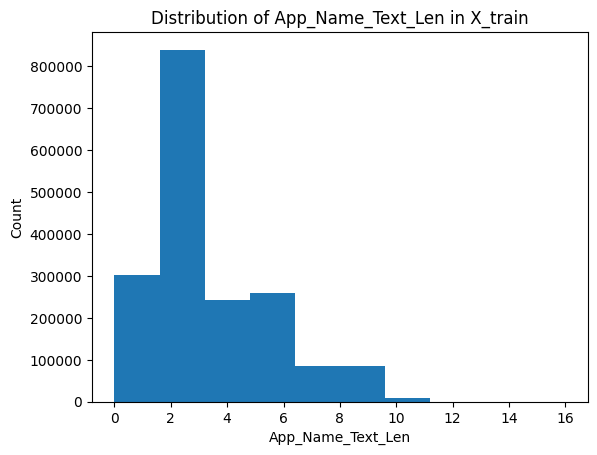

mode: bin2 [10.8, 15.700000000000001) 
ratio: 19.46%


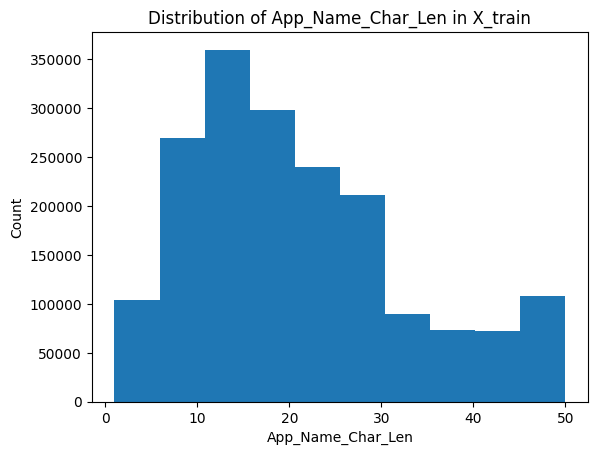

In [35]:
# plot distribution for new features
plot_continuous_distribution(X_train, 'X_train', 'App_Name_Text_Len')
# plot_continuous_distribution(X_test, 'X_test', 'App_Name_Text_Len')
plot_continuous_distribution(X_train, 'X_train', 'App_Name_Char_Len')
# plot_continuous_distribution(X_test, 'X_test', 'App_Name_Char_Len')

- Impute them with median.

In [36]:
median_text_len = X_train['App_Name_Text_Len'].median()
median_char_len = X_train['App_Name_Char_Len'].median()

X_train['App_Name_Text_Len'] = X_train['App_Name_Text_Len'].fillna(median_text_len)
X_test['App_Name_Text_Len'] = X_test['App_Name_Text_Len'].fillna(median_text_len)
X_train['App_Name_Char_Len'] = X_train['App_Name_Char_Len'].fillna(median_text_len)
X_test['App_Name_Char_Len'] = X_test['App_Name_Char_Len'].fillna(median_text_len)

In [37]:
# droping App_Name feature
X_train = X_train.drop('App_Name', axis=1)
X_test = X_test.drop('App_Name', axis=1)

#### 2. App_Id
- Unique identifier with no null values
- Not very important for prediction tasks

In [38]:
all([len(X_train['App_Id'].unique())==len(X_train), len(X_test['App_Id'].unique())==len(X_test)])

True

In [39]:
# dropping App_Id feature
X_train = X_train.drop('App_Id', axis=1)
X_test = X_test.drop('App_Id', axis=1)

#### 3. Category
- dtype: string
- Feature Engineering: OHE

In [40]:
X_train['Category'].unique()

array(['Tools', 'Travel  Local', 'Entertainment', 'Simulation', 'Finance',
       'Lifestyle', 'Education', 'Video Players  Editors', 'Medical',
       'Communication', 'Music  Audio', 'News  Magazines', 'Puzzle',
       'Books  Reference', 'Casual', 'Food  Drink', 'Business',
       'Health  Fitness', 'Arcade', 'Personalization', 'Shopping',
       'Social', 'Maps  Navigation', 'Photography', 'Educational',
       'Music', 'Productivity', 'Trivia', 'Art  Design', 'Action',
       'Auto  Vehicles', 'Sports', 'Strategy', 'House  Home', 'Adventure',
       'Events', 'Beauty', 'Word', 'Racing', 'Role Playing', 'Dating',
       'Board', 'Card', 'Libraries  Demo', 'Casino', 'Weather', 'Comics',
       'Parenting'], dtype=object)

mode: Education 
ratio: 10.41%


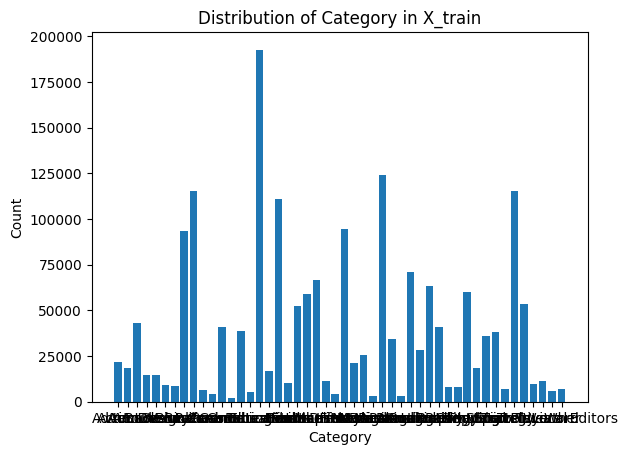

mode: Education 
ratio: 10.41%


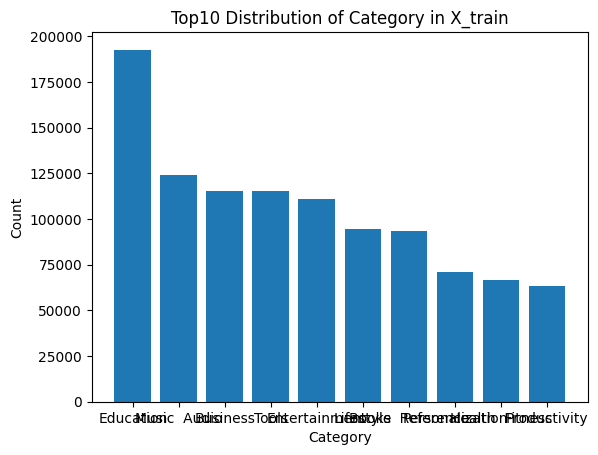

In [41]:
# plot distribution
plot_categorical_distribution(X_train, 'X_train', 'Category')
plot_categorical_distribution(X_train, 'X_train', 'Category', top_10=True)
# plot_categorical_distribution(X_test, 'X_test', 'Category', top_10=True)

#### 4. Rating_Count
- dtype: float
- Feature Engineering: normalize, log

mode: bin0 [0.0, 13855757.0) 
ratio: 100.0%


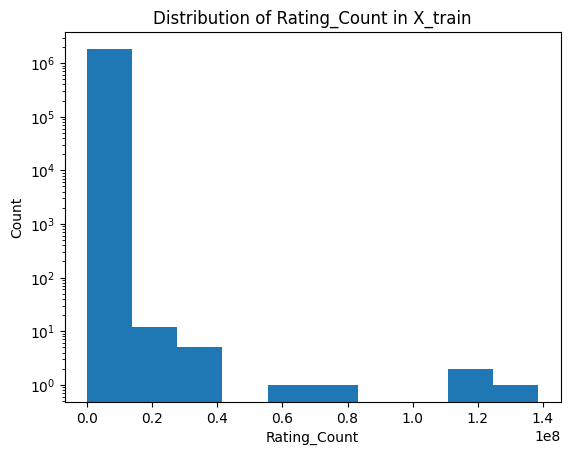

mode: bin0 [0.0, 12020619.0) 
ratio: 100.0%


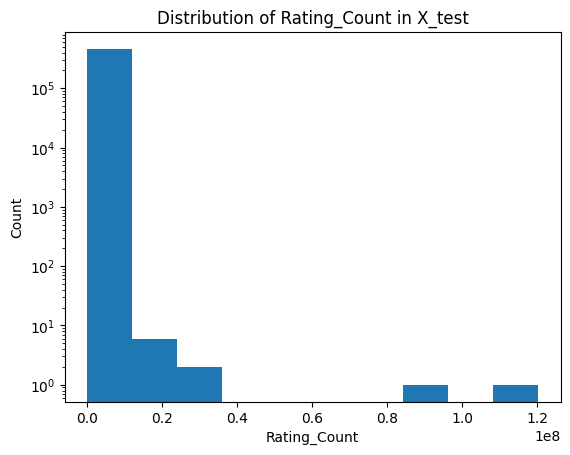

In [42]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Rating_Count', log=True)
plot_continuous_distribution(X_test, 'X_test', 'Rating_Count', log=True)

- Since it is very skewed, we should log this feature.

In [43]:
# using log1p to avoid division by 0 error
X_train['Log_Rating_Count'] = np.log1p(X_train['Rating_Count'])
X_test['Log_Rating_Count'] = np.log1p(X_test['Rating_Count'])

In [44]:
# dropping "Rating_Count"
X_train = X_train.drop('Rating_Count', axis=1)
X_test = X_test.drop('Rating_Count', axis=1)

#### 5. Installs
- dtype: string
- As discusssed in the imputation section, we drop this feature since it is just a string version of "Minimum_Count".

In [45]:
# dropping "Installs"
X_train = X_train.drop('Installs', axis=1)
X_test = X_test.drop('Installs', axis=1)

#### 6. Minimum_Installs
- dtype: string
- Feature Engineering: OHE

In [46]:
sorted(X_train['Minimum_Installs'].unique().tolist())

[0.0,
 1.0,
 5.0,
 10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0,
 100000.0,
 500000.0,
 1000000.0,
 5000000.0,
 10000000.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0]

mode: 100.0 
ratio: 19.17%


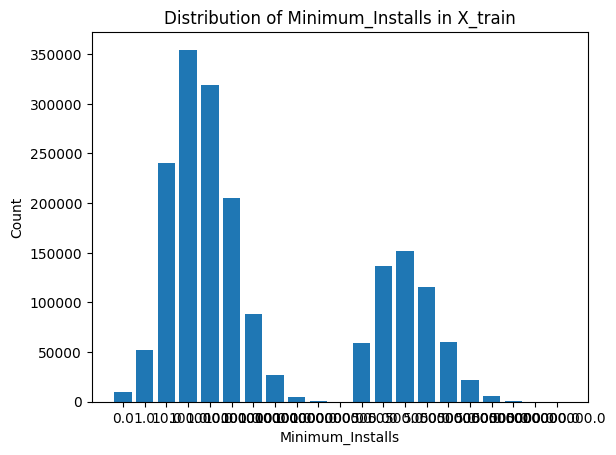

In [47]:
temp = X_train[['Minimum_Installs']].astype(str)
plot_categorical_distribution(temp, 'X_train', 'Minimum_Installs')
# temp = X_test[['Minimum_Installs']].astype(str)
# plot_categorical_distribution(temp, 'X_test', 'Minimum_Installs')

- Surprisingly, this feature has a bimodal distribution
- It catches the unique characteristics of the data, we should include this data.

In [48]:
# convert this to string (categorical) data type
X_train['Minimum_Installs'] = X_train['Minimum_Installs'].astype(str)
X_test['Minimum_Installs'] = X_test['Minimum_Installs'].astype(str)

#### Maximum_Installs
- dtype: float
- Feature Engineering: standardize, log

mode: bin0 [0.0, 976623092.4) 
ratio: 100.0%


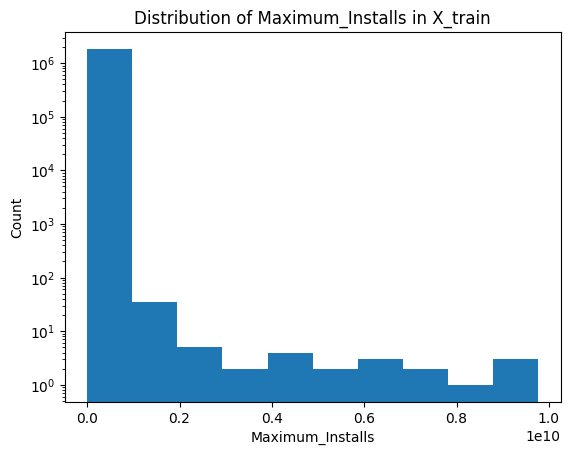

mode: bin0 [0.0, 1205762701.6) 
ratio: 100.0%


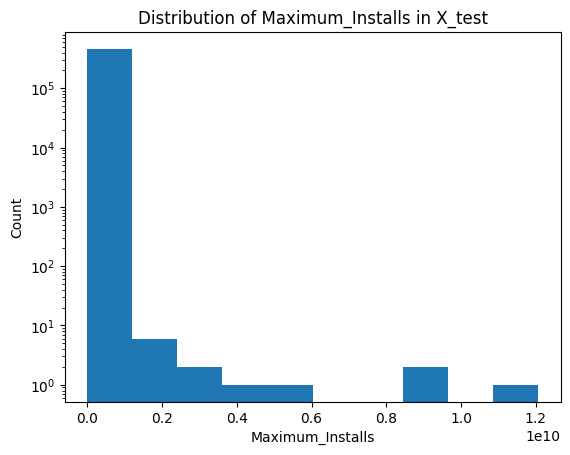

In [49]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Maximum_Installs', log=True)
plot_continuous_distribution(X_test, 'X_test', 'Maximum_Installs', log=True)

- This feature should catch a similar trend to "Minimum_Installs" but is continuous.
- We should apply log since it is very skewed.

In [50]:
X_train['Log_Maximum_Installs'] = np.log1p(X_train['Maximum_Installs'])
X_test['Log_Maximum_Installs'] = np.log1p(X_test['Maximum_Installs'])

In [51]:
# dropping "Maximum_Installs" feature
X_train = X_train.drop('Maximum_Installs', axis=1)
X_test = X_test.drop('Maximum_Installs', axis=1)

#### 8. Free
- dtype: boolean
- Feature Engineering: as it is, drop

mode: True 
ratio: 98.06%


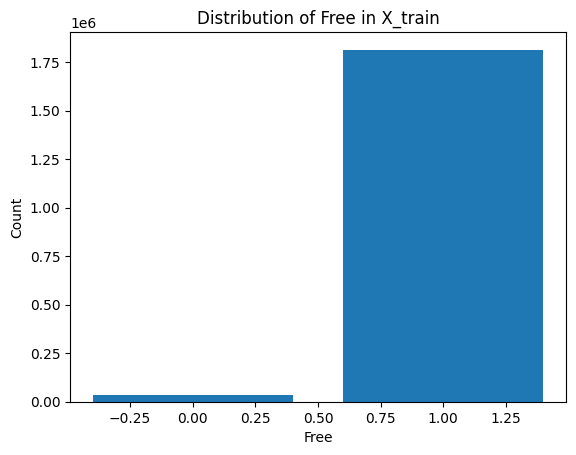

mode: True 
ratio: 98.04%


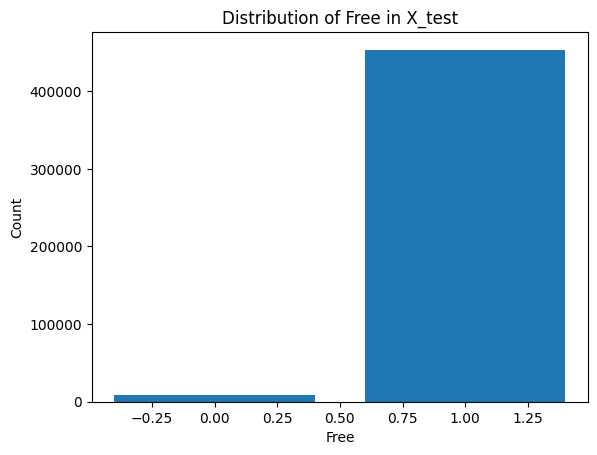

In [52]:
# plot the balance
plot_categorical_distribution(X_train, 'X_train', 'Free')
plot_categorical_distribution(X_test, 'X_test', 'Free')

- This feature is very inbalcanced, we can either resample or drop it.
- Examining Rating distribution below.

mode: bin0 [0.0, 0.5) 
ratio: 46.87%


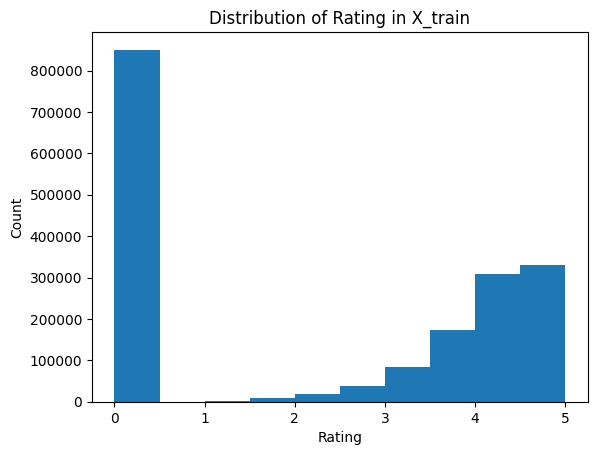

mode: bin0 [0.0, 0.5) 
ratio: 43.27%


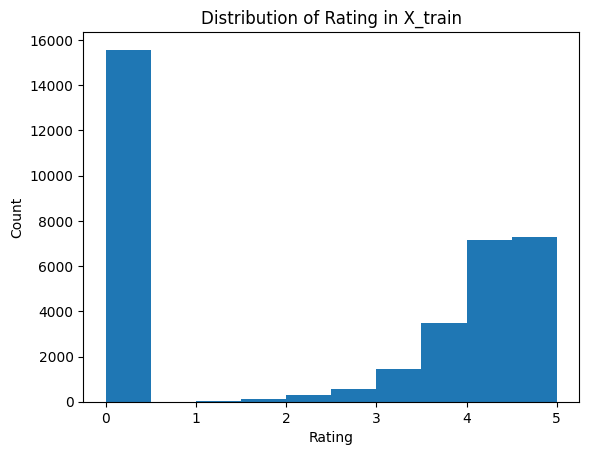

In [53]:
plot_target_hist(X_train, y_train, 'X_train', 'Free')

- There is not significant difference between "Free"==True and "Free"==False
- This feature is not significant.

#### 9. Price
- dtype: float
- Feature Engineering: standardize, log

mode: bin0 [0.0, 40.0) 
ratio: 99.97%


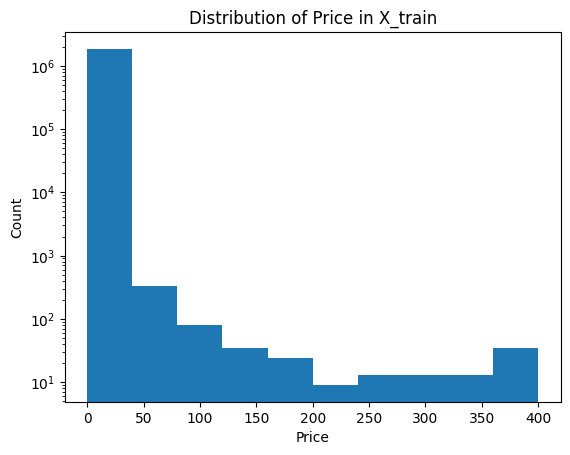

In [54]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Price', log=True)
# plot_continuous_distribution(X_test, 'X_test', 'Price', log=True)

- We should take log for this feature since it is skewed

In [55]:
X_train['Log_Price'] = np.log1p(X_train['Price'])
X_test['Log_Price'] = np.log1p(X_test['Price'])

In [56]:
# dropping "Price" feature
X_train = X_train.drop('Price', axis=1)
X_test = X_test.drop('Price', axis=1)

#### 10. Currency
- dtype: string
- Feature Engineering: OHE, drop

mode: USD 
ratio: 99.94%


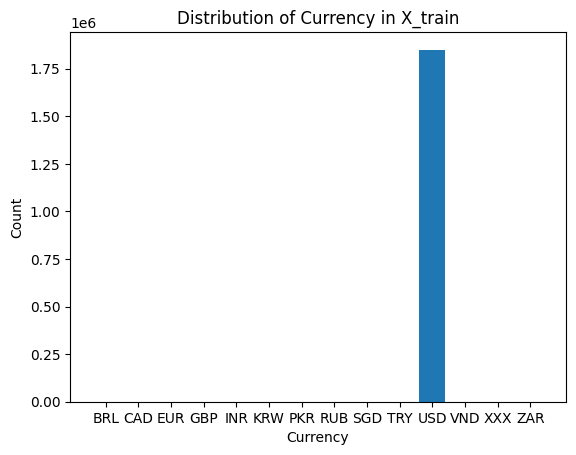

mode: USD 
ratio: 99.95%


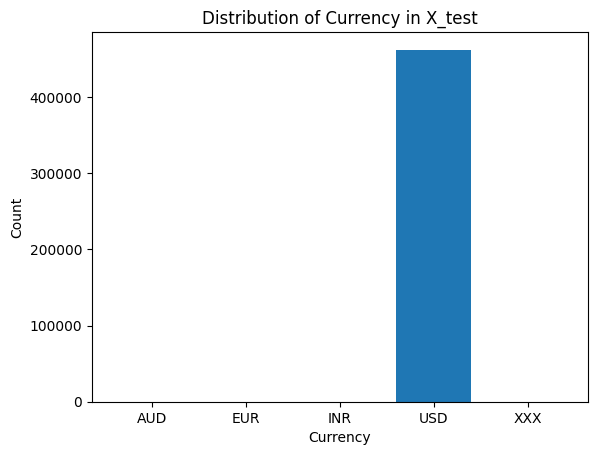

In [57]:
plot_categorical_distribution(X_train, 'X_train', 'Currency')
plot_categorical_distribution(X_test, 'X_test', 'Currency')

- We should drop this feature since 'USD' dominates the instances and test set has 1/3 of categories of training set.

In [58]:
# dropping "Currency" feature
X_train = X_train.drop('Currency', axis=1)
X_test = X_test.drop('Currency', axis=1)

#### 11. Size
- dtype: float (was string, imputation process converted it to float)
- Feature Engineering: standardize, log

mode: bin0 [0.003125, 153.60281250000003) 
ratio: 99.81%


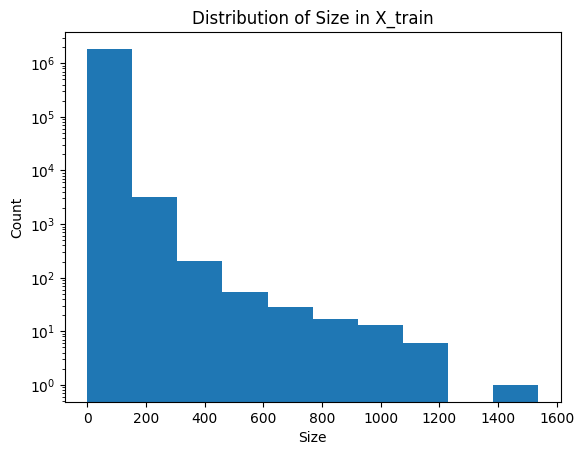

mode: bin0 [0.00322265625, 153.602900390625) 
ratio: 99.82%


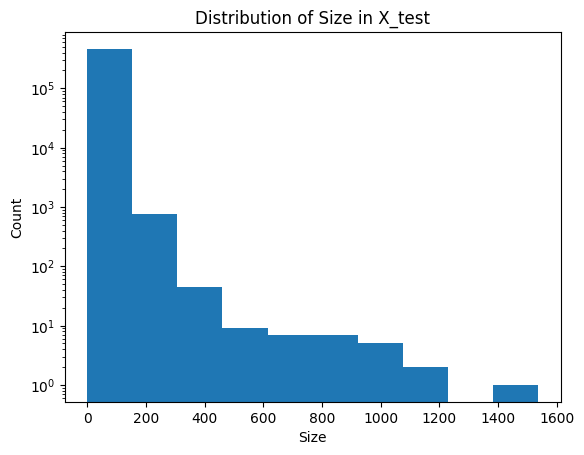

In [59]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Size', log=True)
plot_continuous_distribution(X_test, 'X_test', 'Size', log=True)

- We should take log since this feature is also skewed.

In [60]:
X_train['Log_Size'] = np.log1p(X_train['Size'])
X_test['Log_Size'] = np.log1p(X_test['Size'])

In [61]:
# dropping "Size" feature
X_train = X_train.drop('Size', axis=1)
X_test = X_test.drop('Size', axis=1)

#### 12. Minimum_Android
- dtype: string
- Feature Engineering: OHE, drop

mode: 4.1 and up 
ratio: 26.14%


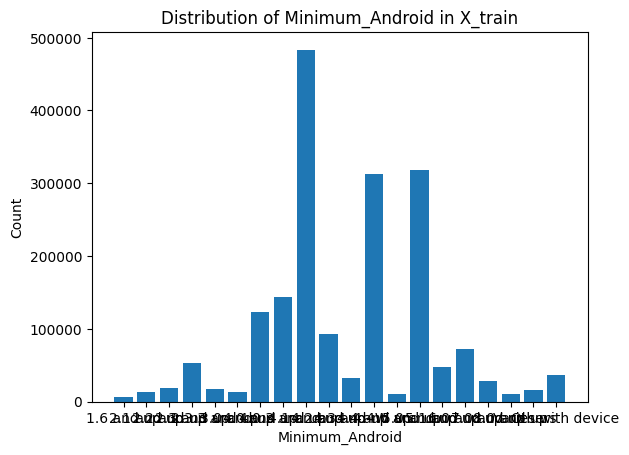

mode: 4.1 and up 
ratio: 26.11%


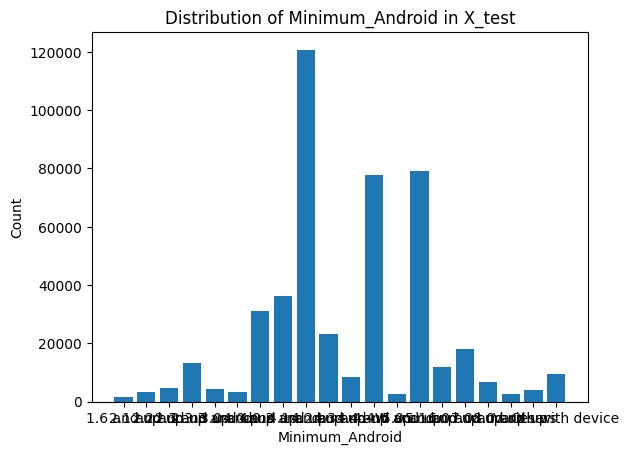

In [62]:
# plot distribution
plot_categorical_distribution(X_train, 'X_train', 'Minimum_Android')
plot_categorical_distribution(X_test, 'X_test', 'Minimum_Android')

- We can OHE this feature later to see if it is relevant to the prediction task.

#### 13. Developer_Id
- dtype: string
- Feature Engineering: drop

In [63]:
X_train.groupby('Developer_Id').size()

Developer_Id
           4318
           1387
            862
            144
             43
           ... 
zztfox        1
zzz1367       6
zzzberg       1
zzzoli        1
zzzwww3       1
Length: 643231, dtype: int64

- It seems there are too many developer_Id values and values with top frequencies are all useless id names.
- We should drop this feature.

In [64]:
# dropping "Developer_Id" feature
X_train = X_train.drop('Developer_Id', axis=1)
X_test = X_test.drop('Developer_Id', axis=1)

#### 14. Developer_Website
- dtype: string
- Feature Engineering: isnull?

(array([312279.,      0.,    718.,   2186.,   5101.,  10956.,  24750.,
         51991.,  93630., 107077.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

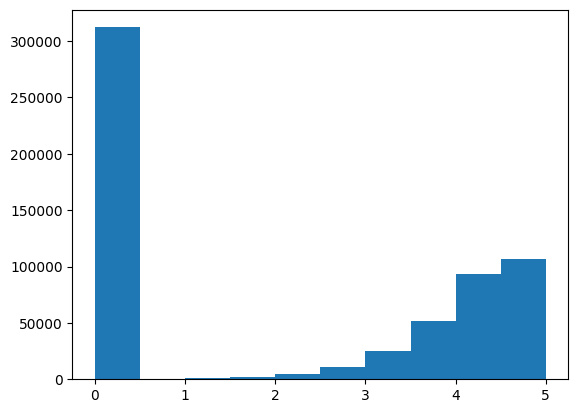

In [65]:
# plot distribution of rating for isnull? == True and isnull? == False
temp = pd.concat([X_train, y_train], axis=1)
plt.hist(temp[temp['Developer_Website'].isnull()].Rating)

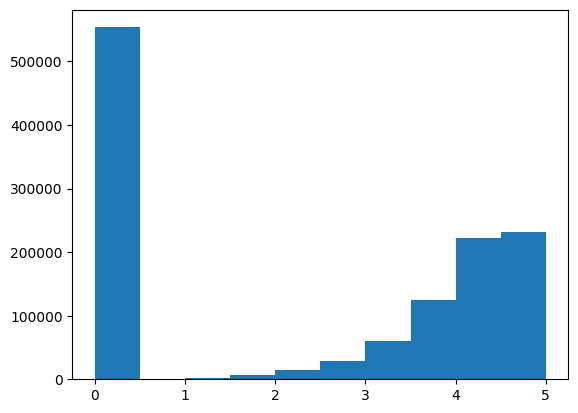

In [66]:
plt.hist(temp[~temp['Developer_Website'].isnull()].Rating);

- Observed no significant difference between the trend of rating with developer website and the trend of rating without developer website.
- We should drop this feature.

In [67]:
# dropping "Developer_Website" feature
X_train = X_train.drop('Developer_Website', axis=1)
X_test = X_test.drop('Developer_Website', axis=1)

#### 15. Developer_Email
- dtype: string
- Feature Engineering: domain

In [68]:
# extract domains of emails
temp_domains = X_train['Developer_Email'].str.extract(r"\.(\w+)$")
temp_domains.groupby(0).size().sort_values(ascending=False)/len(temp_domains)*100

0
com           81.131783
net            1.445669
br             1.187015
org            1.060175
de             1.019804
                ...    
cA             0.000054
builders       0.000054
boston         0.000054
bnpparibas     0.000054
attorney       0.000054
Length: 787, dtype: float64

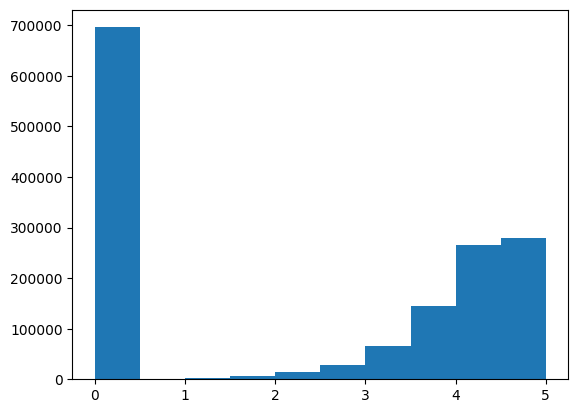

In [69]:
temp = pd.concat([temp_domains, y_train], axis=1)
plt.hist(temp[temp[0]=='com'].Rating);

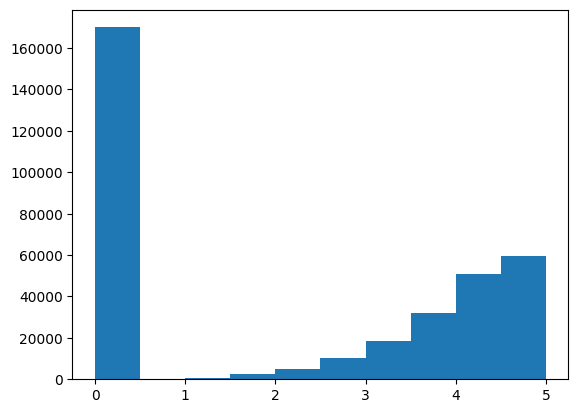

In [70]:
plt.hist(temp[temp[0]!='com'].Rating);

- More than 80% of the domains are com, and there is no signinficant difference between instances with domain com and ones with domain not com.
- We can go ahead dropping this feature.

In [71]:
# dropping "Developer_Email" feature
X_train = X_train.drop('Developer_Email', axis=1)
X_test = X_test.drop('Developer_Email', axis=1)

#### Released
- dtype: string
- Feature Engineering: released_duration (Scraped_Time-Released)

In [72]:
X_train[['Released', 'Scraped_Time']].head()

,Released,Scraped_Time
140961,"Feb 11, 2021",2021-06-15 22:37:46
875217,"Jul 11, 2016",2021-06-16 10:22:46
2234998,"Feb 1, 2019",2021-06-16 11:50:49
719396,"Nov 27, 2019",2021-06-16 07:56:20
347975,"May 29, 2017",2021-06-16 02:15:47


In [73]:
# create a new feature "Days_Released_Scraped"
X_train['Days_Released_Scraped'] = [float('nan')]*len(X_train)
X_test['Days_Released_Scraped'] = [float('nan')]*len(X_test)
def released_duration(row):
    released = row.iloc[X_train.columns.get_loc('Released')]
    if not released or isinstance(released, float):
        return row
    released = datetime.strptime(released, '%b %d, %Y')
    scraped = datetime.strptime(row.iloc[X_train.columns.get_loc('Scraped_Time')].split()[0], '%Y-%m-%d')
    row.iloc[X_train.columns.get_loc('Days_Released_Scraped')] = (scraped-released).days
    return row

In [74]:
%%time
X_train = X_train.apply(released_duration, axis=1)
X_test = X_test.apply(released_duration, axis=1)

CPU times: user 1min 19s, sys: 1.28 s, total: 1min 20s
Wall time: 1min 21s


In [75]:
X_train[['Days_Released_Scraped', 'Released', 'Scraped_Time']].head()

,Days_Released_Scraped,Released,Scraped_Time
140961,124.0,"Feb 11, 2021",2021-06-15 22:37:46
875217,1801.0,"Jul 11, 2016",2021-06-16 10:22:46
2234998,866.0,"Feb 1, 2019",2021-06-16 11:50:49
719396,567.0,"Nov 27, 2019",2021-06-16 07:56:20
347975,1479.0,"May 29, 2017",2021-06-16 02:15:47


mode: bin1 [415.7, 831.4) 
ratio: 25.62%


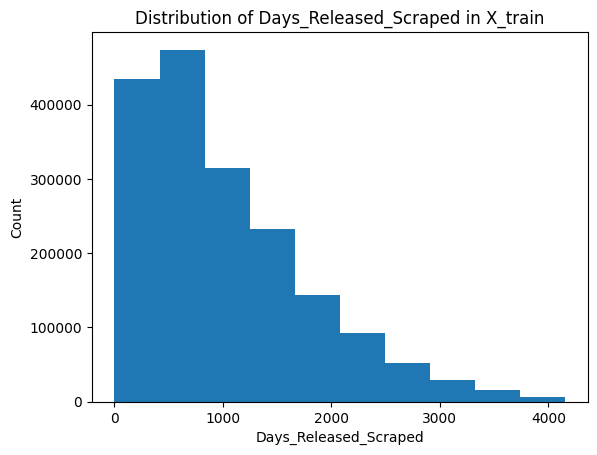

mode: bin1 [416.6, 832.2) 
ratio: 25.48%


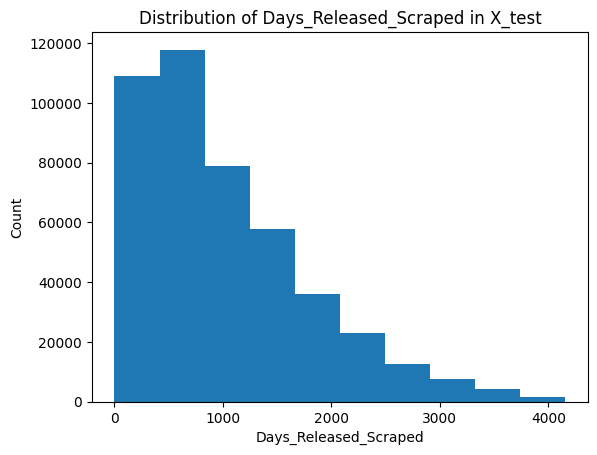

In [76]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Days_Released_Scraped')
plot_continuous_distribution(X_test, 'X_test', 'Days_Released_Scraped')

- It is skewed to the right but we don't have to log this since it will reduce the characteristics.
- We can impute this with median.

In [77]:
median_Days_Released_Scraped = X_train['Days_Released_Scraped'].median()
X_train['Days_Released_Scraped'] = X_train['Days_Released_Scraped'].fillna(median_Days_Released_Scraped)
X_test['Days_Released_Scraped'] = X_test['Days_Released_Scraped'].fillna(median_Days_Released_Scraped)

In [78]:
# dropping "Released" feature
X_train = X_train.drop('Released', axis=1)
X_test = X_test.drop('Released', axis=1)

#### 17. Last_Updated
- dtype: string
- Feature Engineering: updated_to_scraped (Scraped_Time-Last_Updated), approx_service_term (Last_Updated-Released)

In [79]:
X_train[['Last_Updated']].head()

,Last_Updated
140961,"Feb 23, 2021"
875217,"May 29, 2019"
2234998,"Feb 14, 2019"
719396,"Nov 27, 2019"
347975,"Apr 08, 2021"


In [80]:
# create a new feature "Days_Recent_Non_Updated"
X_train['Days_Recent_Non_Updated'] = [float('nan')]*len(X_train)
X_test['Days_Recent_Non_Updated'] = [float('nan')]*len(X_test)
def recent_non_updated_days(row):
    last_updated = datetime.strptime(row.iloc[X_train.columns.get_loc('Last_Updated')], '%b %d, %Y')
    scraped = datetime.strptime(row.iloc[X_train.columns.get_loc('Scraped_Time')].split()[0], '%Y-%m-%d')
    row.iloc[X_train.columns.get_loc('Days_Recent_Non_Updated')] = (scraped-last_updated).days
    return row

In [81]:
%%time
X_train = X_train.apply(recent_non_updated_days, axis=1)
X_test = X_test.apply(recent_non_updated_days, axis=1)

CPU times: user 1min 20s, sys: 1.24 s, total: 1min 21s
Wall time: 1min 21s


In [82]:
X_train[['Days_Recent_Non_Updated', 'Last_Updated', 'Scraped_Time']].head()

,Days_Recent_Non_Updated,Last_Updated,Scraped_Time
140961,112,"Feb 23, 2021",2021-06-15 22:37:46
875217,749,"May 29, 2019",2021-06-16 10:22:46
2234998,853,"Feb 14, 2019",2021-06-16 11:50:49
719396,567,"Nov 27, 2019",2021-06-16 07:56:20
347975,69,"Apr 08, 2021",2021-06-16 02:15:47


mode: bin0 [0.0, 451.0) 
ratio: 54.05%


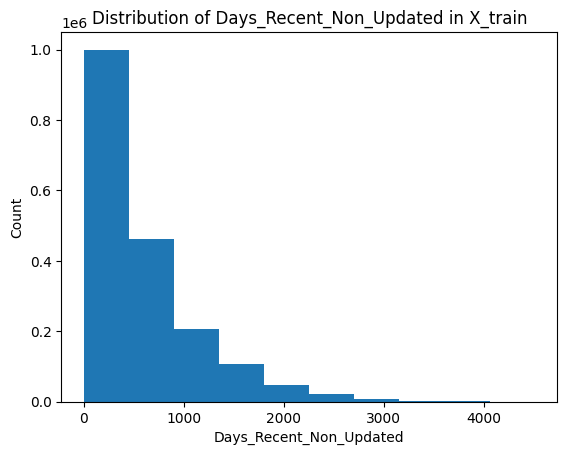

mode: bin0 [0.0, 450.8) 
ratio: 54.08%


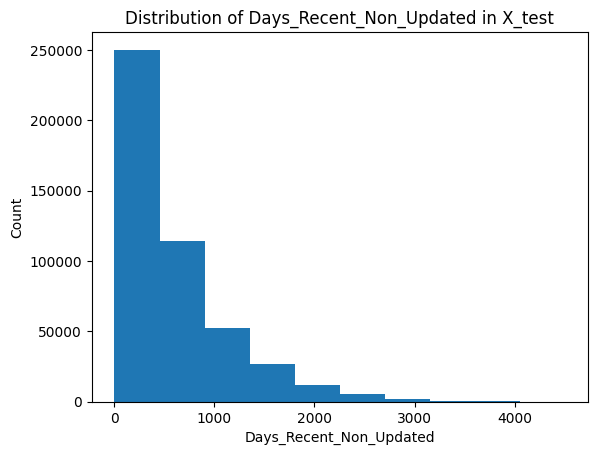

In [83]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Days_Recent_Non_Updated')
plot_continuous_distribution(X_test, 'X_test', 'Days_Recent_Non_Updated')

- There is a similar trend to "Days_Released_Scraped"
- We still don't have to take log for this since the trend is visible without it.

In [84]:
# create a new feature "Approx_Serivce_Term"
X_train['Approx_Service_Term'] = X_train['Days_Released_Scraped']-X_train['Days_Recent_Non_Updated']
X_test['Approx_Service_Term'] = X_test['Days_Released_Scraped']-X_test['Days_Recent_Non_Updated']

mode: bin4 [-553.1999999999998, 231.0) 
ratio: 54.37%


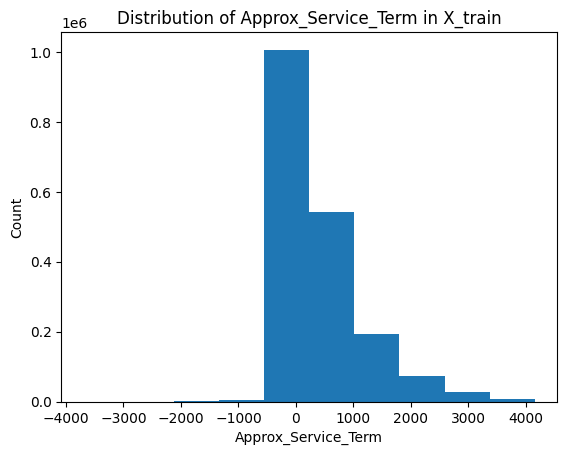

mode: bin4 [-552.4000000000001, 232.0) 
ratio: 54.42%


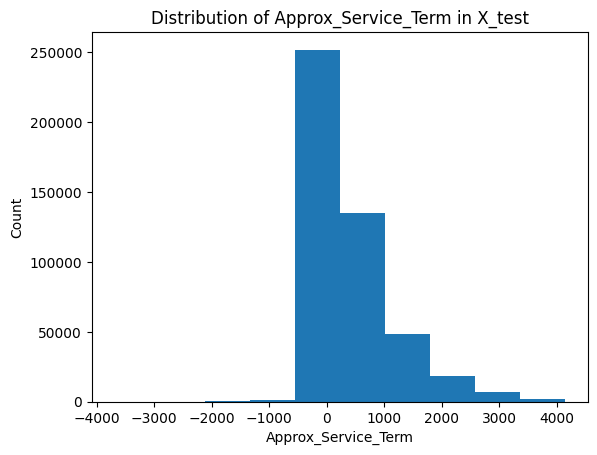

In [85]:
# plot distribution
plot_continuous_distribution(X_train, 'X_train', 'Approx_Service_Term')
plot_continuous_distribution(X_test, 'X_test', 'Approx_Service_Term')

- There are some (potential) invalid inputs that are "Days_Recent_Non_Updated" > "Days_Released_Scraped". It could be correct since they might update the app first and release it.
- Roughly, without considering the negative values, it has a similar trend to "Days_Recent_Non_Updated".

In [86]:
# dropping "Last_Updated" feature
X_train = X_train.drop('Last_Updated', axis=1)
X_test = X_test.drop('Last_Updated', axis=1)

#### 18. Content_Rating
- dtype: string
- Feature Engineering: OHE

In [87]:
X_train['Content_Rating'].unique()

array(['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
       'Adults only 18+', 'Unrated'], dtype=object)

- There are only 6 unique categories in this feature - we can OHE this later too.

#### 19. Privacy_Policy
- dtype: string
- Feature Engineering: isnull?

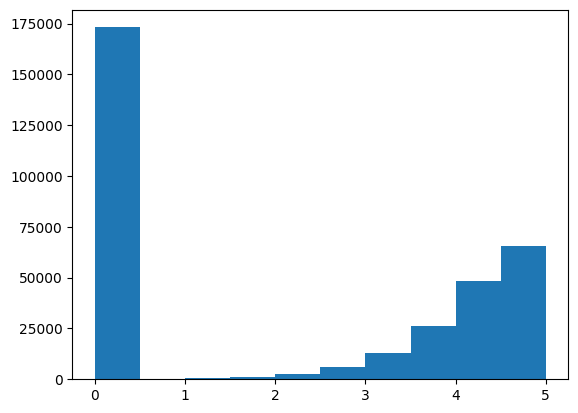

In [88]:
# plot Rating distribution of isnull? == True and isnull? == False
temp = pd.concat([X_train, y_train], axis=1)
plt.hist(temp[temp['Privacy_Policy'].isnull()].Rating);

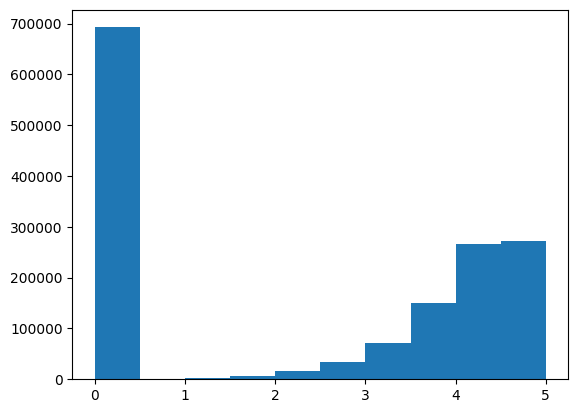

In [89]:
plt.hist(temp[~temp['Privacy_Policy'].isnull()].Rating);

- We can have this new feature since it is balanced and has slightly different trends between True and False.

In [90]:
X_train['Privacy_Policy_Null'] = X_train['Privacy_Policy'].isnull().astype(int)
X_test['Privacy_Policy_Null'] = X_test['Privacy_Policy'].isnull().astype(int)

In [91]:
# dropping "Privacy_Policy" feature
X_train = X_train.drop('Privacy_Policy', axis=1)
X_test = X_test.drop('Privacy_Policy', axis=1)

#### 20. Ad_Supported
- dtype: boolean
- Feature Engineering: as it is

mode: False 
ratio: 50.25%


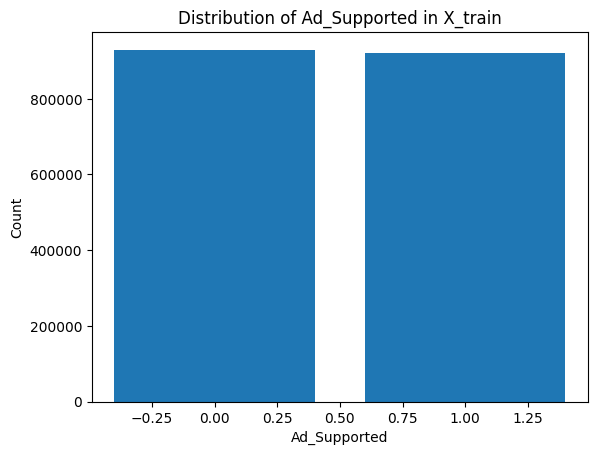

mode: False 
ratio: 50.24%


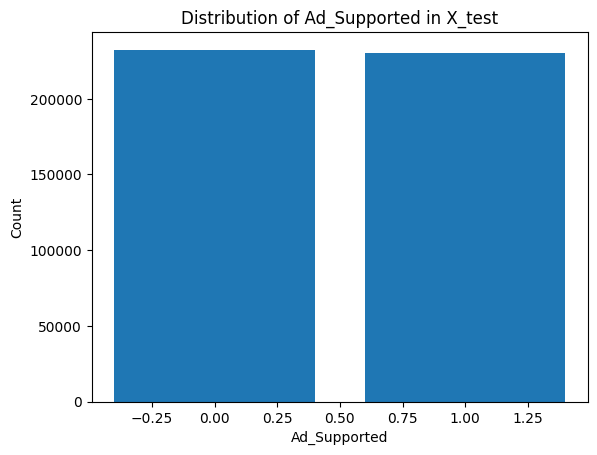

In [92]:
# plot distribution to see balance
plot_categorical_distribution(X_train, 'X_train', 'Ad_Supported')
plot_categorical_distribution(X_test, 'X_test', 'Ad_Supported')

- It is very well balanced. We should keep this.

In [93]:
# convert it into int data type
X_train['Ad_Supported'] = X_train['Ad_Supported'].astype(int)
X_test['Ad_Supported'] = X_test['Ad_Supported'].astype(int)

#### 21. In_App_Purchases
- dtype: boolean
- Feature Engineering: as it is

mode: False 
ratio: 91.55%


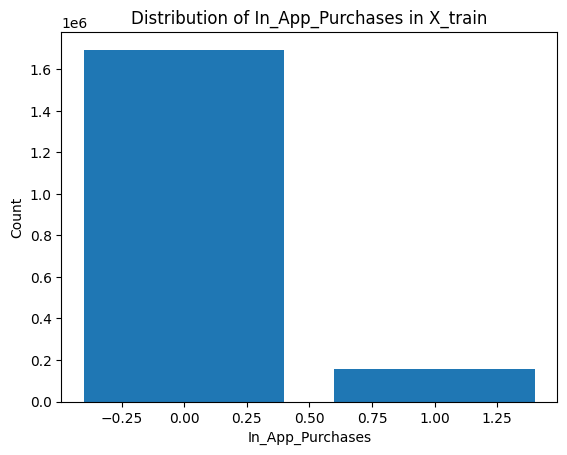

mode: False 
ratio: 91.58%


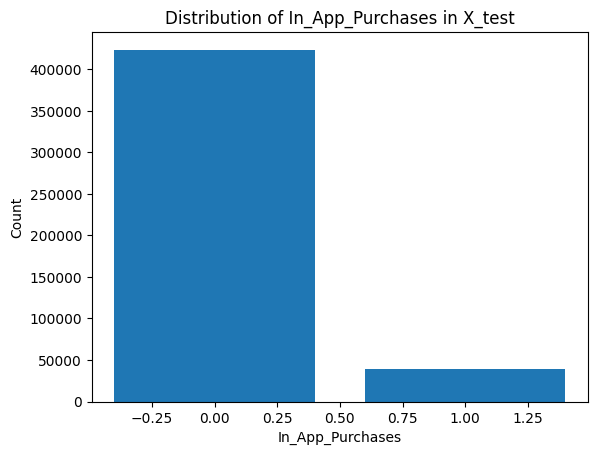

In [94]:
# plot distribution to see balance
plot_categorical_distribution(X_train, 'X_train', 'In_App_Purchases')
plot_categorical_distribution(X_test, 'X_test', 'In_App_Purchases')

- It is unbalanced.
- Check the distribution of rating by each category of this feature.

mode: bin0 [0.0, 0.5) 
ratio: 49.2%


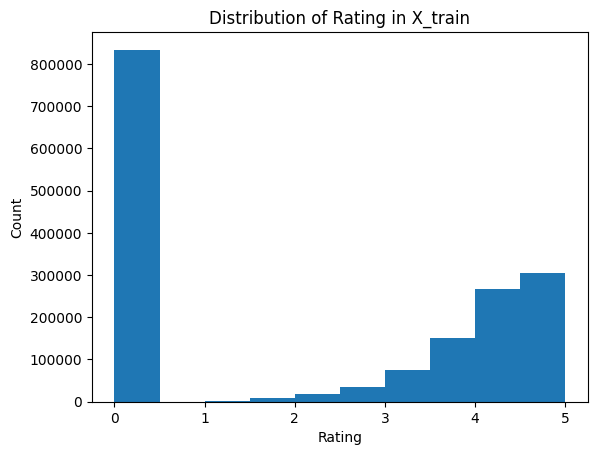

mode: bin8 [4.0, 4.5) 
ratio: 31.31%


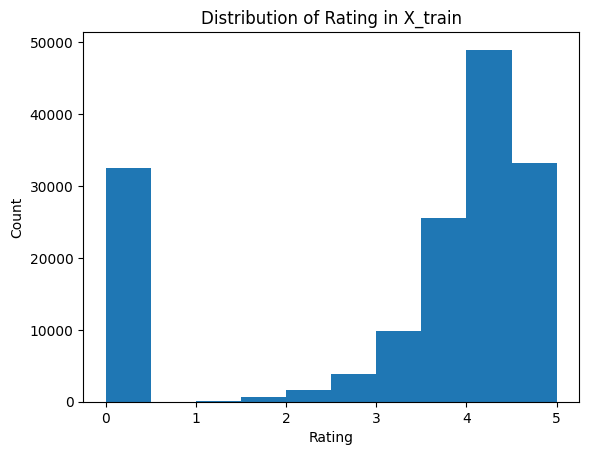

In [95]:
# plot distributions of Rating by True and False in this feature
plot_target_hist(X_train, y_train, 'X_train', 'In_App_Purchases')

- We got an interesting result - modes are not even close between distributions.
- We can still keep this but need to be careful if it introduces noises.

In [96]:
# convert it into int data type
X_train['In_App_Purchases'] = X_train['In_App_Purchases'].astype(int)
X_test['In_App_Purchases'] = X_test['In_App_Purchases'].astype(int)

#### 22. Editors_Choice
- dtype: boolean
- Feature Engineering: as it is

mode: False 
ratio: 99.96%


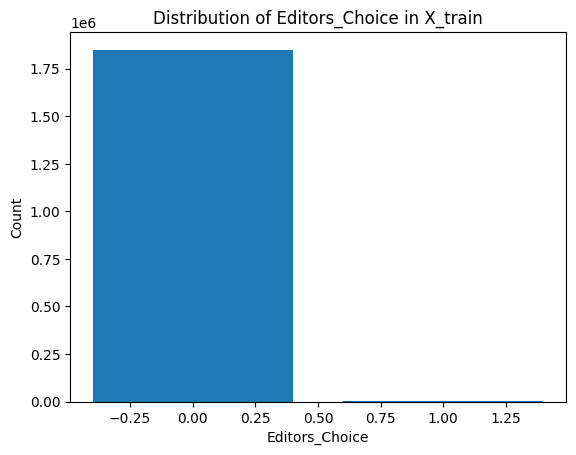

mode: False 
ratio: 99.96%


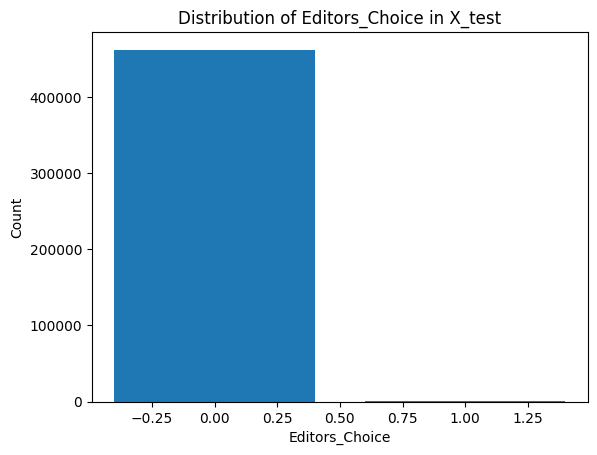

In [97]:
# plot distribution to see the balance
plot_categorical_distribution(X_train, 'X_train', 'Editors_Choice')
plot_categorical_distribution(X_test, 'X_test', 'Editors_Choice')

- This feature is extremely unbalanced.
- We should avoid using this feature even Rating plot shows some interesting fact.

mode: bin0 [0.0, 0.5) 
ratio: 46.82%


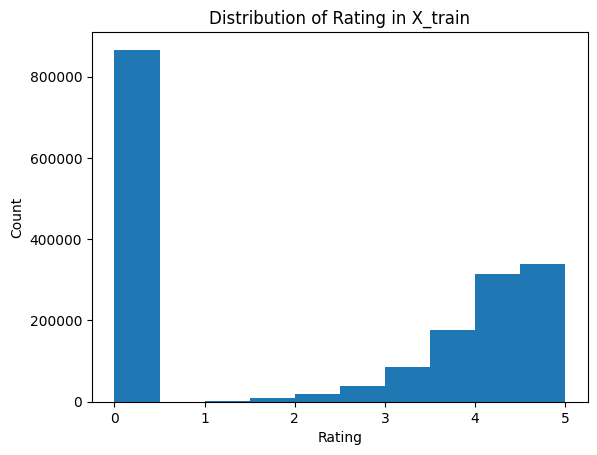

mode: bin8 [4.380000000000001, 4.640000000000001) 
ratio: 41.38%


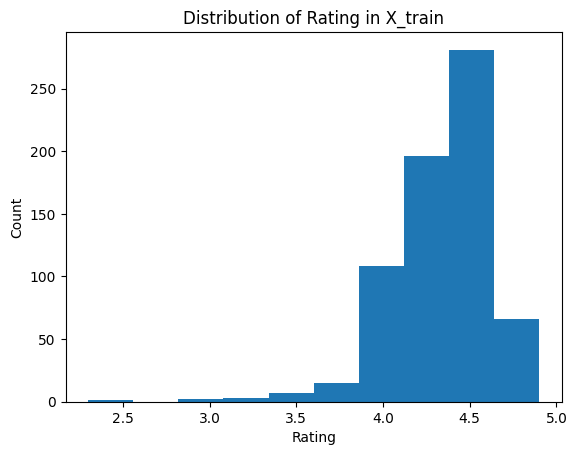

In [98]:
# plot distributions of Rating by True and False in this feature
plot_target_hist(X_train, y_train, 'X_train', 'Editors_Choice')

- Basically it tells that instances with "Editors_Choice" == True share the higher rating mean/median/mode.
- However, the number of these instances is extremely small, we can avoid this feature or let a model handle it by its weighting system.
- Let's keep this feature and we can decide either remove or keep it later.

In [99]:
# convert it into int data type
X_train['Editors_Choice'] = X_train['Editors_Choice'].astype(int)
X_test['Editors_Choice'] = X_test['Editors_Choice'].astype(int)

#### 23. Scraped_Time
- dtype: string
- Feature Engineering: see 16, 17

In [100]:
# dropping "Scraped_Time" feature
X_train = X_train.drop('Scraped_Time', axis=1)
X_test = X_test.drop('Scraped_Time', axis=1)

In [101]:
print(f"X_train Null: \n{X_train.isnull().sum()} \n")
print(f"X_test Null: \n{X_test.isnull().sum()}")

X_train Null: 
Category                   0
Minimum_Installs           0
Free                       0
Minimum_Android            0
Content_Rating             0
Ad_Supported               0
In_App_Purchases           0
Editors_Choice             0
App_Name_Text_Len          0
App_Name_Char_Len          0
Log_Rating_Count           0
Log_Maximum_Installs       0
Log_Price                  0
Log_Size                   0
Days_Released_Scraped      0
Days_Recent_Non_Updated    0
Approx_Service_Term        0
Privacy_Policy_Null        0
dtype: int64 

X_test Null: 
Category                   0
Minimum_Installs           0
Free                       0
Minimum_Android            0
Content_Rating             0
Ad_Supported               0
In_App_Purchases           0
Editors_Choice             0
App_Name_Text_Len          0
App_Name_Char_Len          0
Log_Rating_Count           0
Log_Maximum_Installs       0
Log_Price                  0
Log_Size                   0
Days_Released_Scraped      0

### One-Hot Encoding

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1850355 entries, 140961 to 2219110
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Category                 object 
 1   Minimum_Installs         object 
 2   Free                     bool   
 3   Minimum_Android          object 
 4   Content_Rating           object 
 5   Ad_Supported             int64  
 6   In_App_Purchases         int64  
 7   Editors_Choice           int64  
 8   App_Name_Text_Len        float64
 9   App_Name_Char_Len        float64
 10  Log_Rating_Count         float64
 11  Log_Maximum_Installs     float64
 12  Log_Price                float64
 13  Log_Size                 float64
 14  Days_Released_Scraped    float64
 15  Days_Recent_Non_Updated  int64  
 16  Approx_Service_Term      float64
 17  Privacy_Policy_Null      int64  
dtypes: bool(1), float64(8), int64(5), object(4)
memory usage: 320.4+ MB


- Categorical features: 'Category', 'Minimum_Installs', 'Minimum_Android', 'Content_Rating'

In [103]:
categorical_features = ['Category', 'Minimum_Installs', 'Minimum_Android', 'Content_Rating']
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_categorical)
X_train_ohe = pd.DataFrame(data=ohe.transform(X_train_categorical).toarray(), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_ohe = pd.DataFrame(data=ohe.transform(X_test_categorical).toarray(), columns=ohe.get_feature_names_out(), index=X_test.index)

In [104]:
X_train = pd.concat([X_train.drop(categorical_features, axis=1), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(categorical_features, axis=1), X_test_ohe], axis=1)

### Standardization

In [105]:
numerical_feats = ['App_Name_Text_Len', 'App_Name_Char_Len', 'Log_Rating_Count', 'Log_Maximum_Installs', 
                   'Log_Price', 'Log_Size', 'Days_Released_Scraped', 'Days_Recent_Non_Updated', 'Approx_Service_Term']

#### For Tree Regressors

In [106]:
def standardizer(feat):
    epsilon = 1e-5
    return (feat-min(feat))/(max(feat)-min(feat)+epsilon)
for col in numerical_feats:
    X_train[col] = standardizer(X_train[col])
    X_test[col] = standardizer(X_test[col])

### Feature Selection

#### Clustering
- DBSCAN is preferred since we don't know the number of clusters
- KMeans to fix the number of features

In [108]:
%%time
# DBSCAN
# distance_matrix = 1 - np.abs(X_train.corr())
# dbscan = DBSCAN(eps=0.5, min_samples=2, metric='precomputed')
# clusters = dbscan.fit_predict(distance_matrix)
# cluster_df = pd.DataFrame({'Features': X_train.columns, 'Clusters': clusters})

# selected_features_dbscan = []
# for cluster_id in cluster_df['Clusters'].unique():
#     # cluster -1 is noise
#     if cluster_id == -1:
#         continue
#     features = cluster_df[cluster_df['Clusters']==cluster_id]['Features']
#     variances = X_train[features].var()
#     selected_features_dbscan.append(variances.idxmax())
# if 'Rating_Count' not in selected_features_dbscan:
#     selected_features_dbscan.append('Rating_Count')

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


In [109]:
%%time
# KMeans
# distance_matrix = 1 - np.abs(X_train.corr())
# n = 80
# kmeans = KMeans(n_clusters=n, random_state=SEED, n_init=10)
# cluster_labels = kmeans.fit_predict(distance_matrix)
# cluster_df = pd.DataFrame({'Features': X_train.columns, 'Clusters': cluster_labels})
# selected_features_kmeans = []
# for cluster_id in cluster_df['Clusters'].unique():
#     # cluster -1 is noise
#     if cluster_id == -1:
#         continue
#     features = cluster_df[cluster_df['Clusters']==cluster_id]['Features']
#     variances = X_train[features].var()
#     selected_features_kmeans.append(variances.idxmax())

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 1.67 μs


#### Correlations
- SelectKBest with f_regression, still need to select the number of features i.e. k

In [110]:
# SelectKBest
feature_selector = SelectKBest(score_func=f_regression, k=80)
kbest_X_train = feature_selector.fit_transform(X_train, y_train)
selected_features_kbest = list(feature_selector.get_feature_names_out())

### Select One Feature Set from Above

In [111]:
# assign your choice of selection method right below this line
selection_method = selected_features_kbest
print(f"The number of features after clustering: {len(selection_method)}")
print(f"Selected features: {selection_method}")
X_train_final = X_train[selection_method]
X_test_final = X_test[selection_method]

The number of features after clustering: 80
Selected features: ['Ad_Supported', 'In_App_Purchases', 'Editors_Choice', 'App_Name_Text_Len', 'App_Name_Char_Len', 'Log_Rating_Count', 'Log_Maximum_Installs', 'Log_Size', 'Days_Released_Scraped', 'Days_Recent_Non_Updated', 'Approx_Service_Term', 'Privacy_Policy_Null', 'Category_Action', 'Category_Adventure', 'Category_Arcade', 'Category_Beauty', 'Category_Board', 'Category_Books  Reference', 'Category_Business', 'Category_Card', 'Category_Casino', 'Category_Casual', 'Category_Entertainment', 'Category_Events', 'Category_Finance', 'Category_Food  Drink', 'Category_Health  Fitness', 'Category_House  Home', 'Category_Lifestyle', 'Category_Medical', 'Category_News  Magazines', 'Category_Personalization', 'Category_Photography', 'Category_Productivity', 'Category_Puzzle', 'Category_Racing', 'Category_Role Playing', 'Category_Shopping', 'Category_Simulation', 'Category_Social', 'Category_Strategy', 'Category_Tools', 'Category_Travel  Local', 'Cate

## 3. Training

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# postprocessing
# Rating_Count_test was defined in the beginning of the notebook
def postprocess(y_pred):
    ret = y_pred
    assert len(y_pred)==len(Rating_Count_test)
    for i, rating_count in enumerate(Rating_Count_test):
        if rating_count==0.0: ret[i] = 0.0
    return ret
    
def output_metrics(y_test, y_pred):
    print("Metrics:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"R^2: {r2_score(y_test, y_pred)}")

def result(model, model_name):
    model.fit(X_train_final, y_train)
    y_pred = postprocess(model.predict(X_test_final))
    print(f"{model_name} performance summary:")
    output_metrics(y_test, y_pred)

### Benchmark

In [113]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=SEED, n_jobs=-1)
rfr.fit(Rating_Count_train, y_train)
y_pred_threshold = postprocess(rfr.predict(Rating_Count_test))
output_metrics(y_test, y_pred_threshold)

Metrics:
RMSE: 0.49896151859710813
MAE: 0.2803389922523632
R^2: 0.9439271367688927


### Model Selection

In [125]:
def cross_valid(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'R^2'])
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        metrics.loc[len(metrics)] = [np.sqrt(mean_squared_error(y_val, pred)), mean_absolute_error(y_val, pred), r2_score(y_val, pred)]
    return metrics

- We are doing manual hyperparameter tuning in the below cell because it takes so much time to train these models, especially MLPRegressor (~30mins). This is simply because the dataset has a lot of instances for local (not professional like super computer) environment.
- We tried to use GridSearchCV but it cannot be run within the memory of either Jupyter Notebook or Colab. Unfortunately, we cannot tune hyperparameters here automatically.

In [126]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=SEED, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=SEED)
mlp = MLPRegressor(random_state=SEED)

In [127]:
%%time
model_dict = {
    "RandomForestRegressor": rfr,
    "GradientBoostingRegressor": gbr,
    "MLPRegressor": mlp
}

for model_name, model in model_dict.items():
    print(f"Cross Validation for {model_name}:\n{cross_valid(model, X_train_final, y_train)}")
    result(model, model_name)

Cross Validation for RandomForestRegressor:
       RMSE       MAE       R^2
0  0.451280  0.246213  0.954151
1  0.453320  0.246599  0.953746
2  0.453055  0.247049  0.953752
3  0.452527  0.245710  0.953876
4  0.453514  0.246595  0.953637
RandomForestRegressor performance summary:
Metrics:
RMSE: 0.4520812000599684
MAE: 0.24482412420853736
R^2: 0.9539688821700495
Cross Validation for GradientBoostingRegressor:
       RMSE       MAE       R^2
0  0.447763  0.250728  0.954862
1  0.449608  0.250763  0.954500
2  0.450014  0.251613  0.954371
3  0.449149  0.250359  0.954562
4  0.450378  0.251448  0.954276
GradientBoostingRegressor performance summary:
Metrics:
RMSE: 0.44825696704925355
MAE: 0.248794439877211
R^2: 0.9547443586573215
Cross Validation for MLPRegressor:
       RMSE       MAE       R^2
0  0.438115  0.245092  0.956787
1  0.440248  0.247131  0.956375
2  0.440184  0.259607  0.956343
3  0.438874  0.251586  0.956617
4  0.441505  0.248590  0.956060
MLPRegressor performance summary:
Metrics:

## Summary

- We successfully beat the benchmark in any metrics! Yay!!
- MLP outperforms surprisingly but takes too much runtime.
- In the future project, we can:
    - More hyperparameter tuning
    - Find the optimal number of features to solve trade-off (scores vs runtime) issue
    - Deep learning